In [27]:
# !pip install imgur-downloader
# !pip install python-magic

In [28]:
# no web cache, file check instead

In [29]:
from pymongo import MongoClient
import requests
from pathlib import Path
import pandas as pd
import glob
from PIL import Image
from io import BytesIO
from matplotlib.pyplot import imshow
import numpy as np
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import json
import magic

from imgur_downloader import ImgurDownloader

In [36]:
mongo = MongoClient('172.17.0.1', 27017)
db = mongo['bad-vis']
posts = db['posts']
dlresults = db['dlresults']

In [31]:
images_dir = Path('./images')

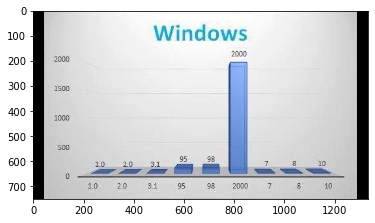

In [6]:
post = posts.find_one()
r = requests.get(post['preview']['url'])
pil_image = Image.open(BytesIO(r.content))
imshow(np.asarray(pil_image))

In [17]:
def get_content_type_ext (content_type, req=None):
    content_type = content_type.lower()
    if content_type == 'image/jpeg' or content_type == 'image/jpg':
        return '.jpg'
    elif content_type == 'image/png':
        return '.png'
    elif content_type == 'image/gif':
        return '.gif'
    elif content_type == 'image/webp':
        return '.webp'
    elif content_type.startswith('image/svg'):
        return '.svg'
    elif content_type == 'image/*' and req:
        return get_content_type_ext(magic.from_buffer(req.content, mime=True))
    else:
        print(f'Unknow content-type: {content_type}')
        return ''

def download_image (post, t='preview', outdir=None):
    if t in post:
        if type(post[t]) == str:
            link = post[t]
        else:
            link = post[t]['url']
    else:
        link = ''
    if not outdir:
        outdir = t
    result = {
        'id': post['id'],
        'post_id': post['post_id'],
        'link': link,
        'dest': images_dir/outdir/post['post_id']
    }

    if len(glob.glob(f'{result["dest"]}.*')) != 0:
        result['status'] = 'exists'
        return result
    else:
        result['dest'].parent.mkdir(parents=True, exist_ok=True)
    
    if not link or link == 'None' or type(link) != str:
        result['status'] = 'invalid_url'
        return result
    
    try:
        if t == 'external_link':
            if 'imgur.com' in link and not (link.endswith('.jpg') or link.endswith('.png')):
                filename, skipped = ImgurDownloader(link,
                                                    dir_download=result['dest'].parent,
                                                    file_name=result['id'],
                                                    delete_dne=True).save_images()
                if skipped != 0:
                    result['status'] = 'imgur_dne'
                else:
                    result['status'] = 'downloaded'
                return result
            elif 'viz.wtf' in link:
                result['status'] = 'skip_wtf-viz'
                return result
            elif 'twitter.com' in link:
                result['status'] = 'skip_twitter'
                return result
            elif 'youtube.com' in link or 'youtu.be' in link:
                result['status'] = 'skip_youtube'
                return result
            elif 'vimeo.com' in link:
                result['status'] = 'skip_vimeo'
                return result
            elif 'reddit.com/r' in link:
                result['status'] = 'skip_subreddit'
                return result
            elif 'reddit.com/user' in link:
                result['status'] = 'skip_redditor'
                return result

        r = requests.get(link)
        result['request_status'] = r.status_code
        if result['request_status'] >= 400:
            if result['request_status'] == 404:
                result['status'] = 'not_found'
            else:
                result['status'] = 'http_error'
            return result

        result['ext'] = get_content_type_ext(r.headers.get('content-type'), r)
        if result['ext'] == '':
            result['status'] = 'invalid_content_type'
            print(f'id: {result["id"]} link: {result["link"]}')
            return result

        result['output'] = f'{result["dest"]}{result["ext"]}'
        with open(result['output'], 'wb') as f:
            f.write(r.content)
        result['status'] = 'downloaded'
        return result
    except Exception as inst:
        print(f"Download error: {post['post_id']} {link} {inst}")
        result['status'] = 'download_error'
        return result
    
    return result

In [8]:
for post in [posts.find_one()]:
    result = download_image(post, t='preview')
    print(result)

{'id': '66i283', 'post_id': 'reddit/dataisugly/66i283', 'link': 'https://preview.redd.it/9fxvy22dypsy.jpg?auto=webp&s=421b84d5fd5bddcac76f006c4905f51cba5c5e7a', 'dest': PosixPath('images/preview/reddit/dataisugly/66i283'), 'status': 'exists'}


In [9]:
for post in [posts.find_one()]:
    result = download_image(post, t='preview')
    print(result)

{'id': '66i283', 'post_id': 'reddit/dataisugly/66i283', 'link': 'https://preview.redd.it/9fxvy22dypsy.jpg?auto=webp&s=421b84d5fd5bddcac76f006c4905f51cba5c5e7a', 'dest': PosixPath('images/preview/reddit/dataisugly/66i283'), 'status': 'exists'}


In [10]:
for post in [posts.find_one()]:
    result = download_image(post, t='thumbnail')
    print(result)

{'id': '66i283', 'post_id': 'reddit/dataisugly/66i283', 'link': 'https://b.thumbs.redditmedia.com/_T2JYLoBm8DA2KV9-a5i189q2tyqRXFnB9l9RcVmhPU.jpg', 'dest': PosixPath('images/thumbnail/reddit/dataisugly/66i283'), 'status': 'exists'}


In [18]:
for post in [posts.find_one({'id': 'd3mkf9'})]:
    result = download_image(post, t='external_link', outdir='preview')
    print(result)

{'id': 'd3mkf9', 'post_id': 'reddit/dataisugly/d3mkf9', 'link': 'https://gfycat.com/pertinentwhiteborer', 'dest': PosixPath('images/preview/reddit/dataisugly/d3mkf9'), 'status': 'exists'}


In [12]:
def parallel (f, params_list, params_dict={}, total=None, n_jobs=-2):
    results = []
    with Parallel(n_jobs=n_jobs, require='sharedmem') as p:
        results = p(delayed(f)(params, **params_dict) for params in tqdm(params_list, total=total))
    return results

In [13]:
dl_preview_results = parallel(download_image, posts.find(), params_dict={'t': 'preview'}, total=posts.estimated_document_count(), n_jobs=20)

In [14]:
dl_thumbnail_results = parallel(download_image, posts.find(), params_dict={'t': 'thumbnail', 'outdir': 'thumbnail'}, total=posts.estimated_document_count(), n_jobs=20)

In [19]:
dl_external_link_results = parallel(download_image, posts.find(), params_dict={'t': 'external_link', 'outdir': 'preview'}, total=posts.estimated_document_count(), n_jobs=20)

Download error: reddit/dataisugly/2p923e http://imgick.oregonlive.com/home/olive-media/width620/img/collegefootball_impact/photo/16557495-mmmain.png HTTPConnectionPool(host='imgick.oregonlive.com', port=80): Max retries exceeded with url: /home/olive-media/width620/img/collegefootball_impact/photo/16557495-mmmain.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9c6c12f780>: Failed to establish a new connection: [Errno -5] No address associated with hostname'))
Unknow content-type: text/html; charset=utf-8
id: 5xz68l link: https://www.kent.ac.uk/careers/pics/Future-Jobs-SM.png
Download error: reddit/dataisugly/29zxab https://fbcdn-sphotos-a-a.akamaihd.net/hphotos-ak-xfa1/t1.0-9/10530866_10152581272476081_4641207393014441201_n.jpg HTTPSConnectionPool(host='fbcdn-sphotos-a-a.akamaihd.net', port=443): Max retries exceeded with url: /hphotos-ak-xfa1/t1.0-9/10530866_10152581272476081_4641207393014441201_n.jpg (Caused by NewConnectionError('<urllib3.connecti

In [20]:
dl_results = [
    (dl_preview_results, 'dl_preview_results.json'),
    (dl_thumbnail_results, 'dl_thumbnail_results.json'),
    (dl_external_link_results, 'dl_external_link_results.json')
]

for results, outfile in dl_results:
    for r in results:
        r['dest'] = str(r['dest'])

    with open(f"./{outfile}", 'w') as f:
        f.write(json.dumps(results))

In [ ]:
df_dl_preview_results = pd.DataFrame.from_records(dl_preview_results)
df_dl_preview_results.loc[(df_dl_preview_results['status'] != 'exists') &
                          (df_dl_preview_results['status'] != 'invalid_url') &
                          (~df_dl_preview_results['status'].isnull()) &
                          (df_dl_preview_results['status'] != 'downloaded')].to_csv('./dl_preview_results.csv', index=False)

In [ ]:
df_dl_thumbnail_results = pd.DataFrame.from_records(dl_thumbnail_results)
df_dl_thumbnail_results.loc[(df_dl_thumbnail_results['status'] != 'exists') &
                            (df_dl_thumbnail_results['status'] != 'invalid_url') &
                            (~df_dl_thumbnail_results['status'].isnull()) &
                            (df_dl_thumbnail_results['status'] != 'downloaded')].to_csv('./dl_thumbnail_results.csv', index=False)

In [26]:
df_dl_external_link_results = pd.DataFrame.from_records(dl_external_link_results)
df_dl_external_link_results.loc[(df_dl_external_link_results['status'] != 'exists') &
                          (df_dl_external_link_results['status'] != 'invalid_url') &
#                           (df_dl_external_link_results['status'] != 'not_found') &
#                           (df_dl_external_link_results['status'] != 'http_error') &
                          (~df_dl_external_link_results['status'].isnull()) &
                          (~df_dl_external_link_results['status'].str.contains('skip_')) &
                          (df_dl_external_link_results['status'] != 'downloaded')].to_csv('./dl_external_link_results.csv', index=False)

In [37]:
dlresults.drop()
dlresults.insert_many(dl_external_link_results)